## Classification using Wingbeat frequency (and higher harmonics) ##

see e.g.
+ http://sites.labic.icmc.usp.br/dfs/ICMLA2013/
+ https://www.researchgate.net/publication/241635781_Towards_Automatic_Classification_on_Flying_Insects_Using_Inexpensive_Sensors
+ Bayesian classifier, https://www.researchgate.net/publication/260716181_Flying_Insect_Classification_with_Inexpensive_Sensors   
https://arxiv.org/abs/1403.2654

---

In [174]:
import pandas as pd
import numpy as np
from scipy import signal
import soundfile as sf
import librosa

from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sn

import os
import time
DATA_PATH1  = "../../../../data/Wingbeats/KaggleMosquitos/"
DATA_PATH2  = "../../../../data/Wingbeats/Koegh_ICML_2013/insect_trap_dataset/"
DATA_PATH3  = "../../../../data/Wingbeats/selectedSignals/"

### Show one recording ###

choose .wav file

In [175]:
import scipy.io.wavfile
from ipyfilechooser import FileChooser

fc = FileChooser(DATA_PATH3)
display(fc)

FileChooser(path='../../../../data/Wingbeats/selectedSignals', filename='', show_hidden='False')

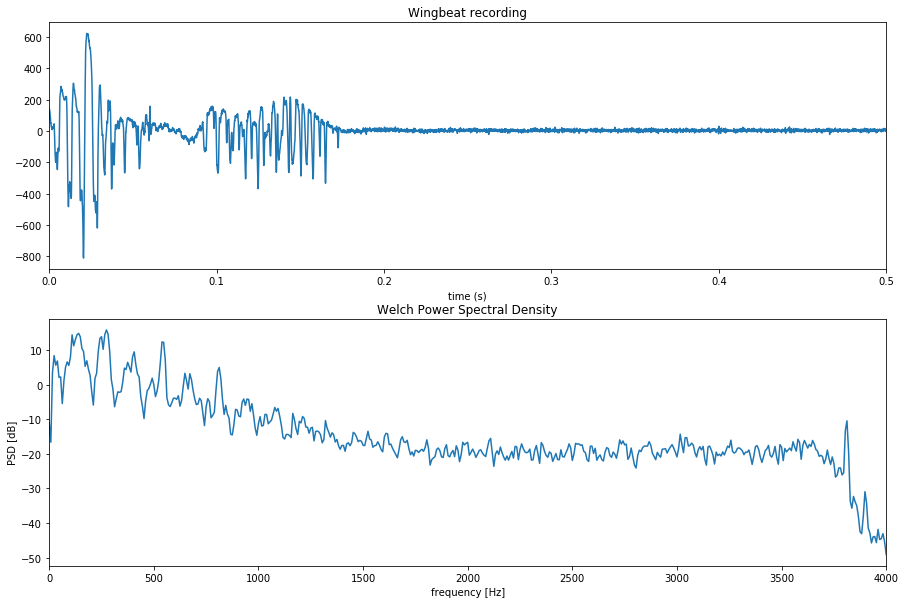

In [196]:
# sarcophagidae_2/signal_5.wav good example
FILE    = fc.selected
sr, sig = scipy.io.wavfile.read(FILE)


#sig     = sig/max(abs(sig))
t       = np.linspace(0, len(sig)/sr, len(sig))

nperseg   = 1024 # for Welch PSD
psd_welch = signal.welch(sig, fs=sr, window='hanning', 
                                   nperseg=nperseg, 
                                   noverlap=nperseg//2+nperseg//4)
psd       = 10*np.log10( psd_welch[1]) # in dB
#freqs_psd = np.linspace(0, sr//2, len(psd))
freqs_psd = psd_welch[0]

plt.figure(figsize = (15,10))
plt.subplot(2, 1, 1)
plt.plot(t, sig)
plt.autoscale(enable=True, axis='x', tight=True)
plt.xlabel('time (s)')
plt.title('Wingbeat recording')
#plt.savefig('signal6.pdf')

plt.subplot(2, 1, 2)
plt.plot(freqs_psd, psd)
plt.autoscale(enable=True, axis='x', tight=True)
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [dB]')
plt.title('Welch Power Spectral Density')
plt.show()


In [119]:
from IPython.display import Audio
Audio(sig, rate=sr) # hear the sound of the wingbeat


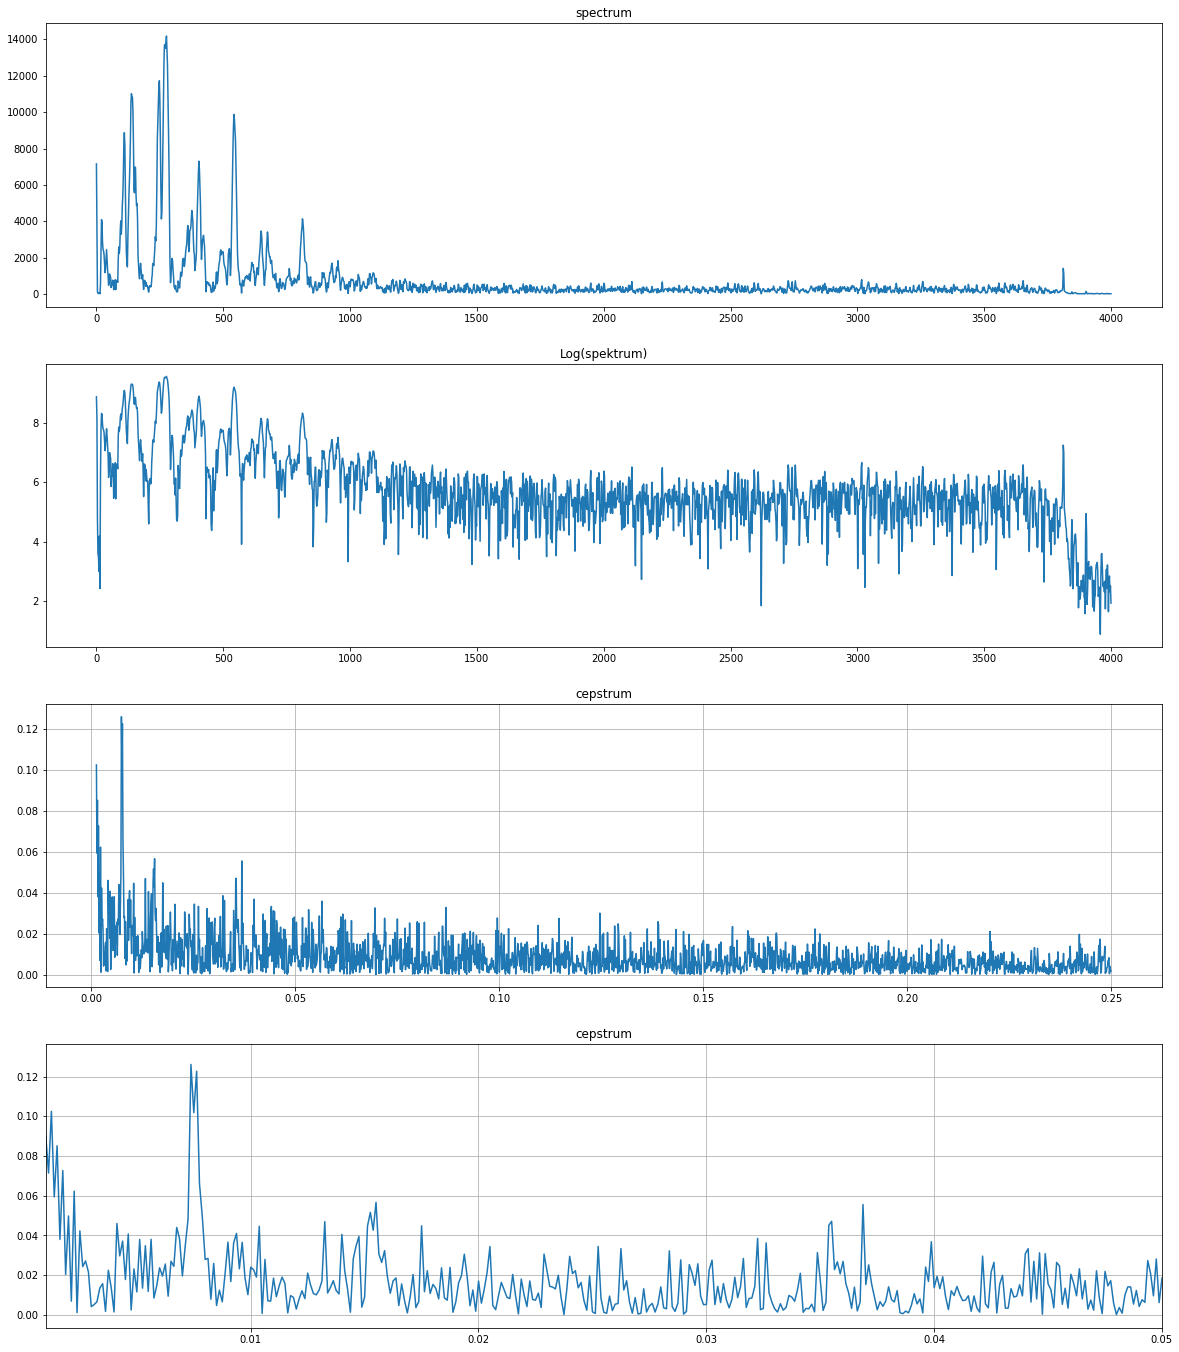

In [197]:
from numpy.fft import fft, ifft
import scipy.signal
#librosa.feature.mfcc(y=y, sr=sr)

n = len(sig)
h = signal.hann(n, sym=True)
sig_h = sig*h

pspectrum = np.abs(fft(sig_h))
lspectrum = np.log(pspectrum)

cepstrum = np.abs(ifft(lspectrum))
freqs    = np.linspace(0, sr//2, len(pspectrum[:n//2]))

plt.figure(figsize =  (20, 24))
plt.subplot(4, 1, 1)
plt.plot(freqs, pspectrum[:n//2])
plt.title("spectrum")
plt.subplot(4, 1, 2)
plt.plot(freqs, lspectrum[:n//2])
plt.title("Log(spektrum)")
plt.subplot(4, 1, 3)
plt.plot(t[10:n//2], cepstrum[10:n//2])
plt.title("cepstrum")
plt.grid(True)

plt.subplot(4, 1, 4)
plt.plot(t[5:n//2], cepstrum[5:n//2])
plt.xlim(0.001, 0.05)
plt.title("cepstrum")
plt.grid(True)

plt.show()

In [198]:
from scipy.signal import argrelmax
import pandas as pd

offset2    = int(sr/1000)   # sample rate / offset : max frequency allowed : 1000 Hz
ind_max2   = np.argmax( cepstrum[offset2:len(cepstrum)//2]) + offset2
cepstrumpd = pd.Series(cepstrum[offset2:len(cepstrum)//2])
max_cep    = cepstrumpd.nlargest() 
f_max = 1./t[ind_max2]
print('cepstrum: base frequency = %.2f' %f_max)



f1         = sr/len(t)
offset1    = int(50/f1)  # min frequency allowed: 50 HZ
ind_max1   =  np.argmax( pspectrum[offset1:len(pspectrum)//2]) + offset1
f_max      = ind_max1*f1
print('spectrum: base frequency = %.2f' %f_max)



cepstrum: base frequency = 135.56
spectrum: base frequency = 276.00


In [199]:
1./t[max_cep.index + offset2]

array([135.55932203, 131.1147541 , 799.8       , 133.3       ,
       999.75      ])

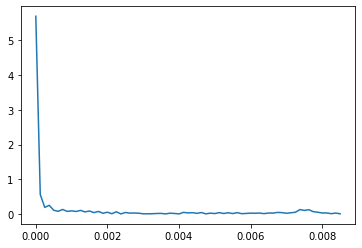

In [200]:
plt.plot( t[:ind_max2+10], cepstrum[:ind_max2+10])
plt.show()